In [0]:
#the required imports
import numpy as np
import pandas as pd
import matplotlib as mlt
import tensorflow as tf
import os
import pathlib
import keras
from keras import regularizers
from keras.models import Model
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense, Input
from keras.layers import Activation, ZeroPadding2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import h5py
from keras.utils import layer_utils

Using TensorFlow backend.


In [0]:
#installation of library used for conversion of .mha scans to n-dimensional numpy arrays
!pip3 install medpy

     |████████████████████████████████| 153kB 2.7MB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753434 sha256=526247ecfe41ef0c2450aff0977b4a887654e760ac2625bf53d0c72476e14223
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


In [0]:
#for connecting the Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#For loading the model and weights obtained from the first training phase
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/localone/localmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("/content/gdrive/My Drive/localone/localweight.h5")

In [0]:
#Freezing all the weights of all convolution layers except for the output layer
for layer in loaded_model.layers[:-1]:
    layer.trainable=False
loaded_model.layers[-1].trainable=True

In [0]:
#To check whether the initial layers have been freezed
loaded_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 56, 56, 4)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 50, 50, 64)   12608       input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 50, 50, 64)   12608       input_5[0][0]                    
__________________________________________________________________________________________________
maximum_13 (Maximum)            (None, 50, 50, 64)   0           conv2d_29[0][0]                  
                                                                 conv2d_30[0][0]            

In [0]:
''' Function for processing the MRI images
Input : paths of all 4 image modalities and the ground truth 
Output : two lists of size 155, one containing processed input of size 240x240x4 stored as n-dimensional numpy array
         the other containing ground truth of dimension 240x240x155 stored as n-dimensional numpy array'''
#the required imports
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from medpy.io import load, save

def gen_image(path1, path2, path3,path4,gtpath):
  #load function converts .mha format into numpy array   
  image_t1, image_header1 = load(path2)
  image_t2, image_header2 =load(path4)
  image_t1c, image_header1c =load(path3)
  image_flair, image_headerr =load(path1)
  image_gt, image_header_gt = load(gtpath)
  t1x, t1y, t1z = image_t1.shape
  final = np.zeros((155, 240, 240,4))
#for extracting each axial slice from each modality and normalising it
  for a in range(0, 155):
    imgt1 = image_t1[:,:,a]
    imgt1 = normalize(imgt1)
    imgt2 = image_t2[:,:,a]
    imgt2 = normalize(imgt2)
    imgt1c = image_t1c[:,:,a]
    imgt1c = normalize(imgt1c)
    imgtflair = image_flair[:,:,a]
    imgtflair = normalize(imgtflair)
    
    #for stacking modalites depth wise and storing them in the list
    final[a] = np.dstack([imgt1, imgt2, imgt1c, imgtflair])

  return final, image_gt

In [0]:
'''This function creates a list of inputs and a list of their corresponding output for training purposes
Inputs : list of inputs of one brain(array), the ground truth numpy array(gt) and a slice_number(between 0-154)
Outputs: a list of patch sized 56x56x4, a list of patch sized 33x33x4, a list of one hot encoded ground truth
a list of the actual ground truth (labelled with integer),  all derived from one slice'''

def create_patch(array, gt,slice_number):
  #initialisation of all the lists and slice number
    patches65=[]
    patches33=[]
    slice = slice_number
    
    gt1=np.zeros((12100,1,1,5))
    actual_gt=np.zeros(12100,dtype=int)
    #the loop moves along one slice and creates input patches of smaller size and also encodes the ground truth to one hot
    k=0
    
    
    l=30
    for i in range(0,110):
      m=30
      for j in range(0,110):
              

              
        patch=array[slice,l:l+56,m:m+56,:]
        s_patch=patch[16:49,16:49,:]
        patches65.append(patch)
        patches33.append(s_patch)
        key=gt[l+32,m+32,slice]
        gt1[k,0,0,key]=1
        actual_gt[k]=key
             
              
        k=k+1
              
        m=m+1
      l=l+1
    
    
    return patches65, patches33, gt1, actual_gt

In [0]:
'''This cell trains the CNN. The path is hard coded, kindly change it as per the need'''

from sklearn.utils import class_weight
from keras import backend as K
smooth=1
#path = '/content/gdrive/My Drive/NNFL Assignment/BRATS 2015 Dataset/Training'
path='/content/gdrive/My Drive/Training'
#path='/content/gdrive/My Drive/BRATS2015_Training'
j=0
i=0
#for extracting dataset files from the training folder
with os.scandir(path) as training:
    for folder1 in training:
        path1 = path + '//' + folder1.name
        with os.scandir(path1) as lgg_hgg:
            for folder2 in lgg_hgg:
                path2 = path1 + '//' + folder2.name
                with os.scandir(path2) as brats:
                    modularity_path = []
                    for folder3 in brats:          
                        path3 = path2 + '/' + folder3.name
                        with os.scandir(path3) as vsdbrain:
                            for file in vsdbrain:
                                if file.name.endswith('mha'):
                                    path4 = path3 + '/' + file.name
                                    modularity_path.append(path4)      
                #pass the modularity path values to gen_image, but what to return and how to manage
                sorted_path = sorted(modularity_path)
                print(sorted_path)
                i=i+1
                #print(i)
                
                

                arr, gt= gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], sorted_path[4])
                #passing the slices one by one
                for s in range(50,80):
                  #extraction of input patches and output patches for training
                  patches65, patches33, gt_pixel, actual_gt = create_patch(arr, gt,s)
                  #class_weights parameter tries to account for disbalance of dataset
                  class_weights = class_weights = class_weight.compute_class_weight('balanced',np.unique(actual_gt),actual_gt)                       
                  sgd = keras.optimizers.SGD(learning_rate=0.005, momentum=0.5, nesterov=False)
                  #compilation and training of the model
                  loaded_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(class_id=0, name = 'normal_tissue_precision'),tf.keras.metrics.Precision(class_id=1, name = 'nec_precision'),tf.keras.metrics.Precision(class_id=2,name = 'edema_precision'),tf.keras.metrics.Precision(class_id=3,name = 'non_enhancing_tumor_precision'),tf.keras.metrics.Precision(class_id=4,name = 'enhancing_tumor_precision'),tf.keras.metrics.Recall(class_id=0,name = 'normal_tissue_recall'),tf.keras.metrics.Recall(class_id=2,name = 'edema_recall'),tf.keras.metrics.Recall(class_id=3,name = 'non_enhancing_tumor_recall'),tf.keras.metrics.Recall(class_id=4,name = 'enhancing_tumor_recall')])
                  loaded_model.fit([patches65, patches33],gt_pixel,epochs=5, class_weight=class_weights)
                  model_json = final_model.to_json()
                  #for saving the model at each iteration can also be done once at the last
                  with open("/content/gdrive/My Drive/localone/localmodelre.json","w") as json_file:
                    json_file.write(model_json)
                  loaded_model.save_weights("/content/gdrive/My Drive/localweightre.h5")
                  print("Saved model to disk")
                  j=j+1
                  print(j)

In [0]:
#loading the post-training model
from keras.models import model_from_json
json_file = open('/content/gdrive/My Drive/localone/localmodelre.json', 'r')
final_model_json = json_file.read()
json_file.close()
final_model = model_from_json(final_model_json)
final_model.load_weights("/content/gdrive/My Drive/localweightre.h5")

In [0]:
final_model.summary()
#compiling the post-trained model
sgd = keras.optimizers.SGD(learning_rate=0.005, momentum=0.5, nesterov=False)
final_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(class_id=0, name = 'normal_tissue_precision'),tf.keras.metrics.Precision(class_id=1, name = 'nec_precision'),tf.keras.metrics.Precision(class_id=2,name = 'edema_precision'),tf.keras.metrics.Precision(class_id=3,name = 'non_enhancing_tumor_precision'),tf.keras.metrics.Precision(class_id=4,name = 'enhancing_tumor_precision'),tf.keras.metrics.Recall(class_id=0,name = 'normal_recall'),tf.keras.metrics.Recall(class_id=1,name = 'nec_recall'),tf.keras.metrics.Recall(class_id=2,name = 'edema_recall'),tf.keras.metrics.Recall(class_id=3,name = 'non_enhancing_tumor_recall'),tf.keras.metrics.Recall(class_id=4,name = 'enhancing_tumor_recall')])

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 56, 56, 4)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 50, 50, 64)   12608       input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 50, 50, 64)   12608       input_5[0][0]                    
__________________________________________________________________________________________________
maximum_13 (Maximum)            (None, 50, 50, 64)   0           conv2d_29[0][0]                  
                                                                 conv2d_30[0][0]            

In [0]:
'''For calculating precision and recall for each class. Dice score is the HM of recall and precision. Hence it is not calculated separately
As of May 2020, evaluate() function gives the metrics for only one input and not for the whole dataset. 
As not all brains and not all the slices contain all kinds of tumor, precision and recall for some classes may come out to be zero due to lack of positive samples.
Change the path as per your need.'''
path = '/content/gdrive/My Drive/Testing'

j=0
i=0
with os.scandir(path) as training:
    for folder1 in training:
        path1 = path + '//' + folder1.name
        with os.scandir(path1) as lgg_hgg:
            for folder2 in lgg_hgg:
                path2 = path1 + '//' + folder2.name
                with os.scandir(path2) as brats:
                    modularity_path = []
                    for folder3 in brats:          
                        path3 = path2 + '/' + folder3.name
                        with os.scandir(path3) as vsdbrain:
                            for file in vsdbrain:
                                if file.name.endswith('mha'):
                                    path4 = path3 + '/' + file.name
                                    modularity_path.append(path4)      
                
                sorted_path = sorted(modularity_path)
                
                
               

                arr, gt= gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], sorted_path[4])
                for s in range(74):
                  patches65, patches33, gt_pixel, actual_gt = create_patch(arr, gt,s)
                results=final_model.evaluate(x=[patches65, patches33],y=gt_pixel)
                  
                print(results)


22500/22500 [==============================] - 32s 1ms/step
[0.31746732002364264, 0.9700000286102295, 0.9967775940895081, 0.4593645930290222, 0.5562584400177002, 0.40241649746894836, 0.48638784885406494, 0.9991669058799744, 0.254743367433548, 0.5003880858421326, 0.43368807435035706, 0.4699872136116028]


In [0]:
#the list of all the metrics.
print(results)


[0.31746732002364264, 0.9700000286102295, 0.9967775940895081, 0.4593645930290222, 0.5562584400177002, 0.40241649746894836, 0.48638784885406494, 0.9991669058799744, 0.254743367433548, 0.5003880858421326, 0.43368807435035706, 0.4699872136116028]


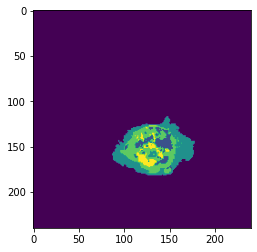

(12100, 1, 1, 5)


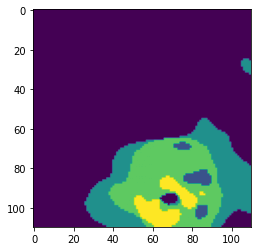

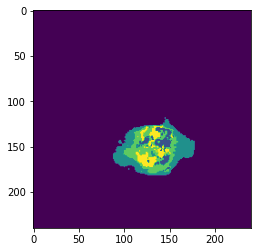

(12100, 1, 1, 5)


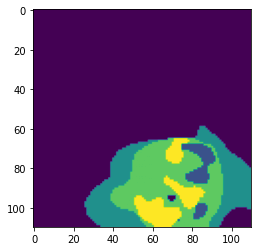

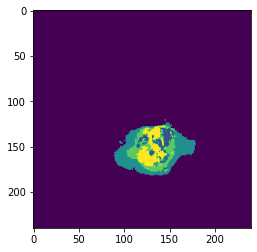

(12100, 1, 1, 5)


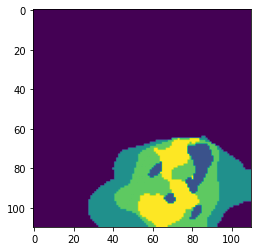

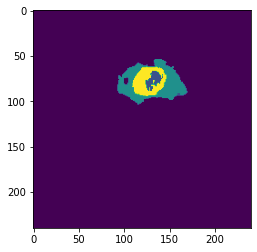

(12100, 1, 1, 5)


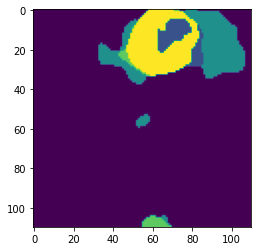

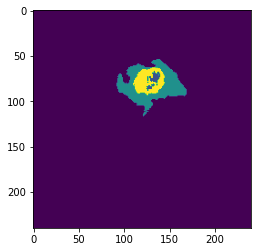

(12100, 1, 1, 5)


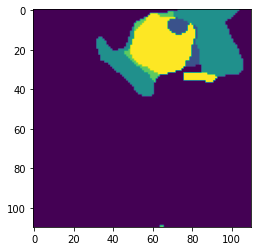

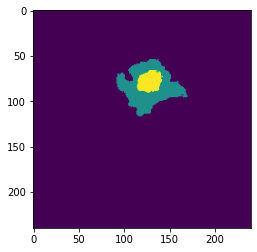

(12100, 1, 1, 5)


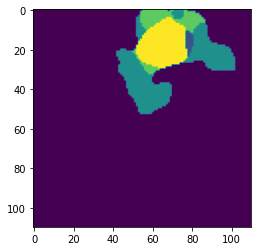

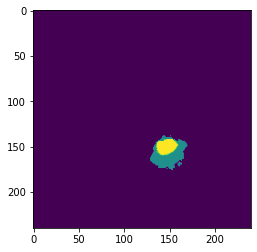

(12100, 1, 1, 5)


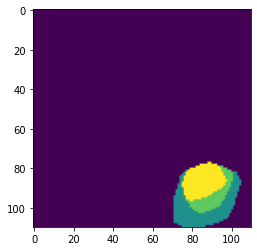

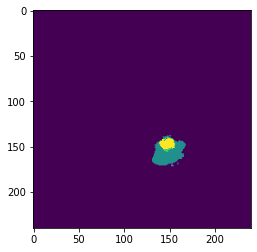

(12100, 1, 1, 5)


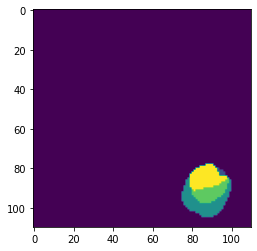

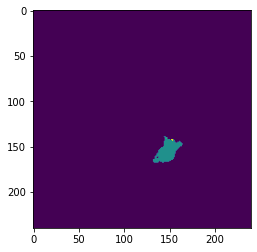

(12100, 1, 1, 5)


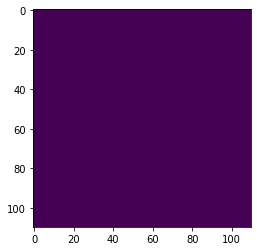

In [0]:
'''For viewing the segmented images in the training dataset. Mostly, slices 60-80 contain information about the tumors.
 Change the path as per the need. The dimension and scope of input image is different from ground truth due to memory problems'''
path = '/content/gdrive/My Drive/Testing'
import matplotlib.cm as cm
import matplotlib.pyplot as plt
j=0
i=0
with os.scandir(path) as training:
    for folder1 in training:
        path1 = path + '//' + folder1.name
        with os.scandir(path1) as lgg_hgg:
            for folder2 in lgg_hgg:
                path2 = path1 + '//' + folder2.name
                with os.scandir(path2) as brats:
                    modularity_path = []
                    for folder3 in brats:          
                        path3 = path2 + '/' + folder3.name
                        with os.scandir(path3) as vsdbrain:
                            for file in vsdbrain:
                                if file.name.endswith('mha'):
                                    path4 = path3 + '/' + file.name
                                    modularity_path.append(path4)      
                
                sorted_path = sorted(modularity_path)
                arr, gt= gen_image(sorted_path[0], sorted_path[1], sorted_path[2], sorted_path[3], sorted_path[4])
                image_t1, image_header1 = load(sorted_path[4])
                for slice in [70,72,75]:
                  ground = image_t1[:,:,slice]
                  plt.imshow(ground)
                  plt.show()
                  patches65, patches33, gt_pixel, actual_gt = create_patch(arr, gt,slice)
                  #prediction of the output
                  predict=final_model.predict(x=[patches65, patches33])
                  print(predict.shape)
                  #conversion of output from one-hot to integer
                  k = np.reshape(predict,(12100,5))
                  m = np.argmax(k,axis =1)
                  #reshaping the output to get a 2D image
                  final = np.reshape(m,(110,110))
                  plt.imshow(final)
                  plt.show() 
                